# Optical Flow with Convolution Neural Networks

The paper's version of optical flow produces a vector <-x, +x, -y, +y, -z, +z>.
Our result vector needs to change in track_object(frame1, frame2, x, y, w, h, steps) - currently the displacement should be `[x,y]`, so we'll just need to do some conditional wizardry and expand it out.

*NOTE:* Prior to running any of this, a virtual environment is needed. Once in the venv, run `pip install -r requirements.txt` to prepare all of the required libraries.

In [11]:
import numpy as np
flow = np.array([-2,3])
final_flow = np.array([0, 0, 0, 0, 0, 0])

if flow[0] < 0:
    final_flow[0] = abs(flow[0])
elif flow[0] > 0:
    final_flow[1] = abs(flow[0])

if flow[1] < 0:
    final_flow[2] = abs(flow[1])
elif flow[1] > 0:
    final_flow[3] = abs(flow[1])
final_flow

array([2, 0, 0, 3, 0, 0])

The videos used are all releaseed under the Creative Commons Attribution 3.0 license.
We can generate the list of all files in the training directory (in this case, a scene from "Big Buck Bunny") as follows:

In [12]:
import os
file_list = os.listdir("bunny")

We'll need to add the directory name to the beginning of each file:

In [13]:
for x in range(len(file_list)):
    file_list[x] = 'bunny/' + file_list[x]

First off, let's look at a couple of optical flow examples.

In [14]:
from optical_flow import run_lk

flow_vector = run_lk(file_list[0], file_list[1], 124, 158, 254, 233, steps=5)
flow_vector

[0, 0.14430177, 0, 0.03125444, 0, 0]

We can track the same bounding box's movement in the next frame as well:

In [15]:
flow_vector = run_lk(file_list[1], file_list[2], 124-flow_vector[0]+flow_vector[1],
                                                 158-flow_vector[2]+flow_vector[3],
                                                 254, 233, steps=5)
flow_vector

[0, 0.11882825, 0, 0.48146176, 0, 0]

Preparing the dataset will use the `prepare_dataset` function in the `optical_flow.py` file. The signature for this function is:
`prepare_dataset(files_list, result_file, x, y, w, h, steps=5)`
The bounding box should be determined for the scene, and consists of the x,y,w,h parameters.

In [16]:
from optical_flow import prepare_dataset
prepare_dataset(file_list, "train-data.csv", 124, 158, 254, 233, steps=5)

To train and evaluate the neural net, we'll use the Lkvf file.

In [17]:
from Lkvf import train
history = train()

Epoch 1/100
149/149 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.3546
Epoch 2/100
149/149 [==============================] - 0s 725us/step - loss: 0.6904 - accuracy: 0.5794
Epoch 3/100
149/149 [==============================] - 0s 726us/step - loss: 0.6845 - accuracy: 0.6969
Epoch 4/100
149/149 [==============================] - 0s 682us/step - loss: 0.6797 - accuracy: 0.7662
Epoch 5/100
149/149 [==============================] - 0s 623us/step - loss: 0.6757 - accuracy: 0.7897
Epoch 6/100
149/149 [==============================] - 0s 734us/step - loss: 0.6717 - accuracy: 0.8121
Epoch 7/100
149/149 [==============================] - 0s 707us/step - loss: 0.6699 - accuracy: 0.8400
Epoch 8/100
149/149 [==============================] - 0s 669us/step - loss: 0.6643 - accuracy: 0.8244
Epoch 9/100
149/149 [==============================] - 0s 644us/step - loss: 0.6608 - accuracy: 0.8333
Epoch 10/100
149/149 [==============================] - 0s 676us/step - los

149/149 [==============================] - 0s 704us/step - loss: 0.1278 - accuracy: 0.9631
Epoch 80/100
149/149 [==============================] - 0s 724us/step - loss: 0.1309 - accuracy: 0.9597
Epoch 81/100
149/149 [==============================] - 0s 720us/step - loss: 0.1371 - accuracy: 0.9519
Epoch 82/100
149/149 [==============================] - 0s 674us/step - loss: 0.1230 - accuracy: 0.9620
Epoch 83/100
149/149 [==============================] - 0s 726us/step - loss: 0.1246 - accuracy: 0.9664
Epoch 84/100
149/149 [==============================] - 0s 861us/step - loss: 0.1218 - accuracy: 0.9575
Epoch 85/100
149/149 [==============================] - 0s 634us/step - loss: 0.1150 - accuracy: 0.9575
Epoch 86/100
149/149 [==============================] - 0s 752us/step - loss: 0.1037 - accuracy: 0.9664
Epoch 87/100
149/149 [==============================] - 0s 633us/step - loss: 0.0792 - accuracy: 0.9765
Epoch 88/100
149/149 [==============================] - 0s 747us/step - loss:

Once we're trained up, we can check some visualizing through matplotlib to get an idea of our accuracy. This can be seen to approach very close to 100% accuracy, and finishes the training and evaluating loop with less than 1% loss.

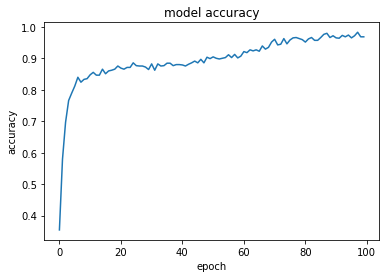

In [18]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

And the loss factor in the model:

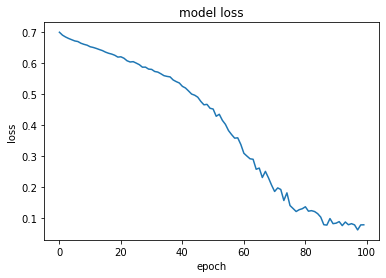

In [19]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Running the new neural network on the correct bounding box for the first two frames gives the following results:

In [20]:
import imageio
from RunLKNN import LK, loadNN

x,y,w,h = 124, 158, 254, 233

first_frame = file_list[0]
second_frame = file_list[1]

LK((imageio.imread(first_frame)[
            :, :, :3].astype(np.float32) / 255.0)[y:y+h, x:x+w], (imageio.imread(second_frame)[
            :, :, :3].astype(np.float32) / 255.0)[y:y+h, x:x+w], loadNN('model.yaml', 'model.h5'))

Loaded model from disk
[[0.02872337 0.0200383  0.04930682 0.06072028 0.02950257 0.03036932]]
[-0.008685067, 0.011413459, 0.00086675026]


[-0.008685067, 0.011413459, 0.00086675026]